In [1]:
%matplotlib notebook

import os
import shutil
from PIL import Image
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.6f}'.format)

pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.max_colwidth', None)  # Display full content of each field

In [2]:
def build_image_list(input_dir):
    data = []

    # Define the valid object classes
    object_classes = {"Comets", "DSO", "Lunar", "Planets"}

    for object_class in object_classes:
        class_dir = os.path.join(input_dir, object_class)
        if not os.path.isdir(class_dir):
            continue

        for object_id_name in os.listdir(class_dir):
            object_id_path = os.path.join(class_dir, object_id_name)
            if not os.path.isdir(object_id_path):
                continue
            object_id = object_id_name.lower()

            # Walk through all subdirectories under the object_id directory
            for root, dirs, files in os.walk(object_id_path):
                if 'ignore.dat' in files:
                    continue

                is_primary = 'primary.dat' in files
                has_thumbnail = 'thumbnail.dat' in files

                for file in files:
                    if file.lower().endswith('.jpg'):
                        full_path = os.path.join(root, file)
                        data.append({
                            "source": full_path,
                            "objectClass": object_class,
                            "objectId": object_id,
                            "primary": is_primary,
                            "thumbnail": has_thumbnail
                        })

    return pd.DataFrame(data)

def add_image_metadata (df_images, df_dso):
    columns_to_merge = ['displayName', 'type']
    df_images = df_images.merge(df_dso[['objectId'] + columns_to_merge], on='objectId', how='left')

    # Add planets, moon, and comet metadata
    df_images.loc[df_images['objectId'] == 'moon', 'displayName'] = 'Moon'
    df_images.loc[df_images['objectId'] == 'venus', 'displayName'] = 'Venus'
    df_images.loc[df_images['objectId'] == 'mars', 'displayName'] = 'Mars'
    df_images.loc[df_images['objectId'] == 'jupiter', 'displayName'] = 'Jupiter'
    df_images.loc[df_images['objectId'] == 'saturn', 'displayName'] = 'Saturn'
    df_images.loc[df_images['objectId'] == 'p12', 'displayName'] = 'Comet 12P/Pons-Brooks'
    df_images.loc[df_images['objectId'] == 'a3', 'displayName'] = 'C/2023 A3 (Tsuchinshan-ATLAS)'

    df_images.loc[df_images['objectClass'] == 'Planets', 'type'] = 'planet'
    df_images.loc[df_images['objectClass'] == 'Lunar', 'type'] = 'moon'
    df_images.loc[df_images['objectClass'] == 'Comets', 'type'] = 'comet'
    
    return df_images

def process_for_website(df, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for _, row in df.iterrows():
        img_type = row['type']
        object_id = row['objectId']
        source_path = row['source']
        is_thumbnail = row['thumbnail']

        # Skip rows without a valid type
        if pd.isna(img_type):
            continue

        # Prepare destination directory based on type
        type_dir = os.path.join(output_dir, img_type)
        os.makedirs(type_dir, exist_ok=True)

        # Build initial filename based on objectId
        base_filename = f"{object_id.replace(' ', '_')}.jpg"

        # Ensure unique filename in main directory
        unique_filename = ensure_unique_filename(type_dir, base_filename)
        target_path = os.path.join(type_dir, unique_filename)

        # Copy the full image
        shutil.copy2(source_path, target_path)

        # If thumbnail is needed, process and save resized image
        if is_thumbnail:
            thumbs_dir = os.path.join(type_dir, 'Thumbs')
            os.makedirs(thumbs_dir, exist_ok=True)

            thumb_filename = ensure_unique_filename(thumbs_dir, base_filename)
            thumb_path = os.path.join(thumbs_dir, thumb_filename)

            with Image.open(source_path) as img:
                width = 540
                aspect_ratio = img.height / img.width
                height = int(width * aspect_ratio)
                resized = img.resize((width, height), Image.LANCZOS)
                resized.save(thumb_path, format='JPEG')


def process_for_mobile(df, output_dir):
    # Filter to include only primary images, excluding Lunar and Comets
    df_mobile = df[(~df['objectClass'].isin(['Comets'])) & (df['primary'] == True)].copy()

    # Add default thumbnail-related columns
    df_mobile['thumbX'] = pd.NA
    df_mobile['thumbY'] = pd.NA
    df_mobile['thumbDim'] = pd.NA
    df_mobile['destination'] = pd.NA # temp for code to size thumb, not used in app
    
    set_mobile_thumb_attributes(df_mobile, 'venus', pd.NA, pd.NA, 100)
    set_mobile_thumb_attributes(df_mobile, 'mars', pd.NA, pd.NA, 200)
    set_mobile_thumb_attributes(df_mobile, 'jupiter', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(df_mobile, 'saturn', pd.NA, pd.NA, 250)
    set_mobile_thumb_attributes(df_mobile, 'm1', pd.NA, pd.NA, 350)
    set_mobile_thumb_attributes(df_mobile, 'm3', pd.NA, pd.NA, 350)
    set_mobile_thumb_attributes(df_mobile, 'm8', 700, 400, 700)
    set_mobile_thumb_attributes(df_mobile, 'm13', pd.NA, pd.NA, 500)
    set_mobile_thumb_attributes(df_mobile, 'm20', 830, 650, 900)
    set_mobile_thumb_attributes(df_mobile, 'm27', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(df_mobile, 'm51', pd.NA, pd.NA, 650)
    set_mobile_thumb_attributes(df_mobile, 'm57', 760, 555, 200)
    set_mobile_thumb_attributes(df_mobile, 'm63', pd.NA, pd.NA, 325)
    set_mobile_thumb_attributes(df_mobile, 'm81', 265, 550, 525)
    set_mobile_thumb_attributes(df_mobile, 'm82', pd.NA, pd.NA, 500)
    set_mobile_thumb_attributes(df_mobile, 'm83', pd.NA, pd.NA, 600)
    set_mobile_thumb_attributes(df_mobile, 'm97', pd.NA, pd.NA, 325)
    set_mobile_thumb_attributes(df_mobile, 'm101', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(df_mobile, 'm104', pd.NA, pd.NA, 325)
    set_mobile_thumb_attributes(df_mobile, 'ngc6960', pd.NA, pd.NA, 400)    
    set_mobile_thumb_attributes(df_mobile, 'ngc2362', 780, 530, 400)
    set_mobile_thumb_attributes(df_mobile, 'ngc7293', pd.NA, pd.NA, 600)
    set_mobile_thumb_attributes(df_mobile, 'ic434', 1815, 570, 600)
    set_mobile_thumb_attributes(df_mobile, 'ic5146', pd.NA, pd.NA, 600)
    set_mobile_thumb_attributes(df_mobile, 'ngc1977', 615, 575, 800)

    os.makedirs(output_dir, exist_ok=True)

    for index, row in df_mobile.iterrows():
        object_id = row['objectId']
        source_path = row['source']

        if pd.isna(object_id):
            continue

        base_filename = f"{object_id.replace(' ', '_')}.webp"
        final_filename = ensure_unique_filename(output_dir, base_filename)
        final_path = os.path.join(output_dir, final_filename)

        with Image.open(source_path) as img:
            resized = resize_image_to_max_resolution(img)
            resized.save(final_path, format='WEBP', lossless=True)
            df_mobile.at[index, 'destination'] = final_path
            
    # Save the DataFrame as JSON
    imagesJson = os.path.join(output_dir, 'images.json')
    df_mobile.drop(columns=['source', 'objectClass', 'type', 'primary', 'destination']).to_json(imagesJson, orient='records', lines=False)
    
    return df_mobile
     
def set_mobile_thumb_attributes(df, objectId, thumbX, thumbY, thumbDim):
    df.loc[df['objectId'] == objectId, 'thumbX'] = thumbX
    df.loc[df['objectId'] == objectId, 'thumbY'] = thumbY
    df.loc[df['objectId'] == objectId, 'thumbDim'] = thumbDim    

def resize_image_to_max_resolution(img, max_height=1080):
    width, height = img.size

    # Only resize if the height is greater than max_height
    if height <= max_height:
        return img.copy()

    # Calculate new width while preserving aspect ratio
    scale = max_height / height
    new_width = int(width * scale)
    new_height = max_height

    return img.resize((new_width, new_height), Image.LANCZOS)


def set_primary_for_unique_object_ids(df):
    # Count occurrences of each objectId
    object_counts = df['objectId'].value_counts()

    # Get objectIds that occur exactly once
    unique_ids = object_counts[object_counts == 1].index

    # Set 'primary' = True for those unique objectIds
    df.loc[df['objectId'].isin(unique_ids), 'primary'] = True

    return df
            
                
def ensure_unique_filename(destination_dir, filename):
    base_name, ext = os.path.splitext(filename)
    unique_filename = filename
    counter = 1

    while os.path.exists(os.path.join(destination_dir, unique_filename)):
        unique_filename = f"{base_name}-{counter}{ext}"
        counter += 1

    return unique_filename

In [3]:
image_source_directory = "/Users/jwatts/Documents/astrophotography/Exports/"
mobile_app_destination = "/Users/jwatts/Documents/astrophotography/Cloud/Mobile/"
web_app_destination = "/Users/jwatts/Documents/astrophotography/Cloud/Web"

# Ensure destination directories exist
os.makedirs(mobile_app_destination, exist_ok=True)
os.makedirs(web_app_destination, exist_ok=True)

# Build up base image list
df_images = build_image_list(image_source_directory)

# fix up a folder naming convention for Moon.
df_images.loc[df_images['objectClass'] == 'Lunar', 'objectId'] = 'moon'

# Load DSO Object Metadata
df_dso = pd.read_json("dso.json", orient='records', lines=False)

# Add Object Metadata
df_images= add_image_metadata (df_images, df_dso)

# Fix Up Primary
df_images= set_primary_for_unique_object_ids(df_images)

# Process list for website
process_for_website(df_images, web_app_destination)

# Process List for Mobile
df_mobile = process_for_mobile(df_images, mobile_app_destination)


In [4]:
df_images[0:200]

,source,objectClass,objectId,primary,thumbnail,displayName,type
0,/Users/jwatts/Documents/astrophotography/Exports/DSO/NGC2362/NGC2362.jpg,DSO,ngc2362,True,False,Tau CMa,cluster
1,/Users/jwatts/Documents/astrophotography/Exports/DSO/M8/M8.jpg,DSO,m8,True,False,Lagoon Nebula,nebula
2,/Users/jwatts/Documents/astrophotography/Exports/DSO/M1/M1.jpg,DSO,m1,True,True,Crab Nebula,nebula
3,/Users/jwatts/Documents/astrophotography/Exports/DSO/M31/M31-90s.jpg,DSO,m31,True,False,Andromeda Galaxy,galaxy
4,/Users/jwatts/Documents/astrophotography/Exports/DSO/NGC6888/NGC6888.jpg,DSO,ngc6888,True,False,Crescent Nebula,nebula
5,/Users/jwatts/Documents/astrophotography/Exports/DSO/M97/m97.jpg,DSO,m97,True,False,Owl Nebula,nebula
6,/Users/jwatts/Documents/astrophotography/Exports/DSO/M101/M101.jpg,DSO,m101,True,False,Pinwheel Galaxy,galaxy
7,/Users/jwatts/Documents/astrophotography/Exports/DSO/M83/m83.jpg,DSO,m83,True,False,Southern Pinwheel Galaxy,galaxy
8,/Users/jwatts/Documents/astrophotography/Exports/DSO/M82/M82.jpg,DSO,m82,True,False,Cigar Galaxy,galaxy
9,/Users/jwatts/Documents/astrophotography/Exports/DSO/M13/m13.jpg,DSO,m13,True,True,Hercules Cluster,cluster


<IPython.core.display.Javascript object>


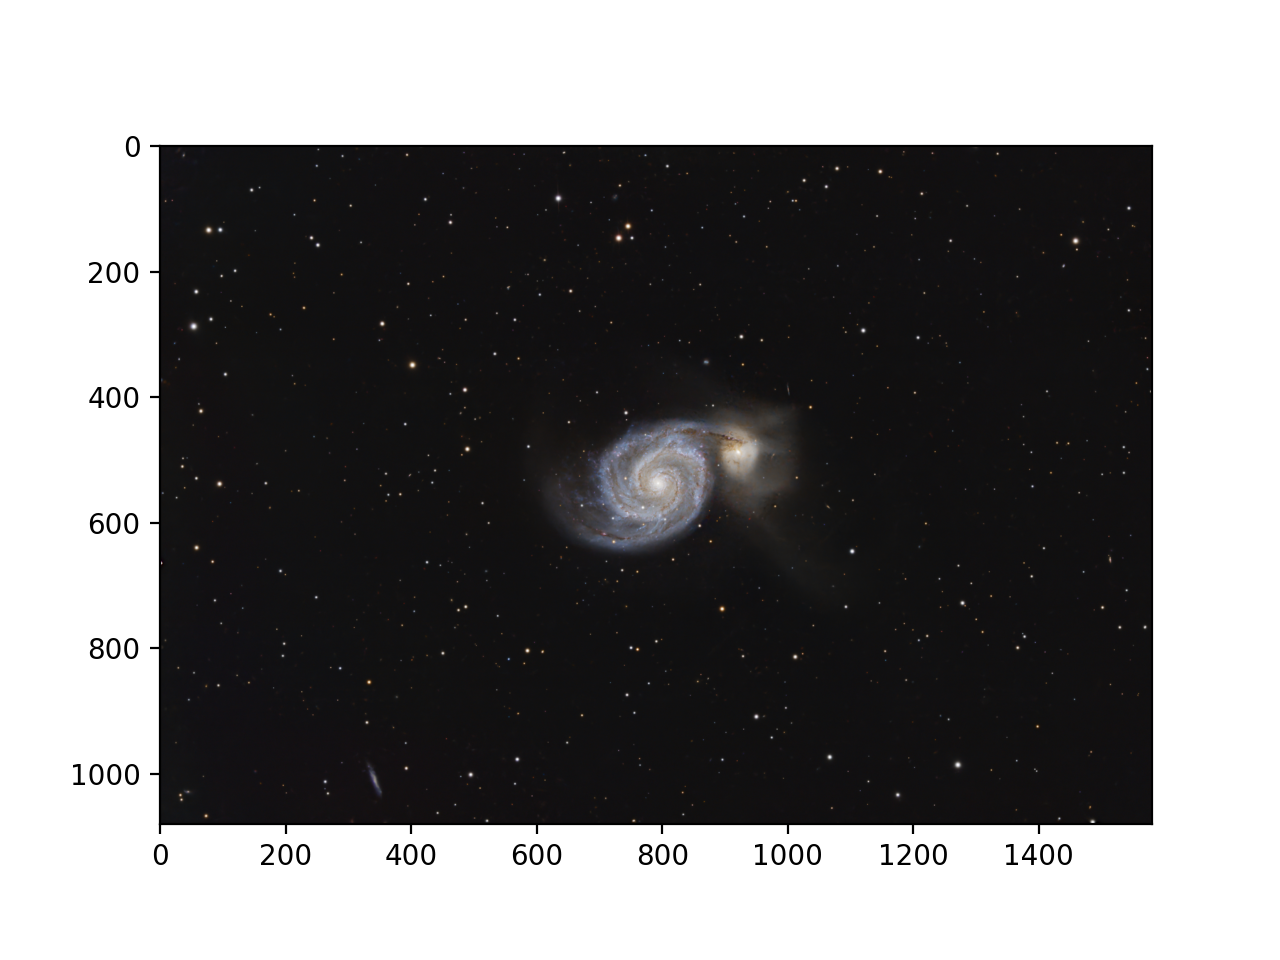

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_name = df_mobile.loc[df_mobile['objectId'] == 'm51', 'destination'].iloc[0]
image = Image.open(image_name)

# Create a plot to display the image
fig, ax = plt.subplots()
ax.imshow(image)

# Function to handle click events
def onclick(event):
    # Get the x and y coordinates of the click
    x, y = int(event.xdata), int(event.ydata)
    print(f'Pixel coordinates: (x: {x}, y: {y})')

# Connect the click event to the handler function
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()